In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]


def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b", n_gen=10):
    gen = list(range(1,n_gen+1))
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [30]:
# population 초기화 함수
def initilization_of_population(size,n_feat,cutoff): # size : chromosome의 수(population size), n_feat : feature의 수, cutoff : 이진값 변환 기준값
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool) # n_feat 수만큼의 array 생성 
        chromosome[:int(cutoff*n_feat)]=False # default : 0.3 = 전체 feature에서 0의 비율         
        np.random.shuffle(chromosome) # 생성된 chromosome 무작위 shuffle
        population.append(chromosome) # population에 chromosome 추가
    return population

# 적합도 평가 함수
def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train) # 생성된 chromosome에 해당하는 feature들로 모델 학습       
        predictions = logmodel.predict(X_test.iloc[:,chromosome]) # 생성된 chromosome에 해당하는 feature들로 예측
        scores.append(accuracy_score(Y_test,predictions)) # accuracy 계산 및 저장
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 

# 확정적 선택법
def selection(pop_after_fit,n_parents): # pop_after_fit : fitness_score 평가 후 score 높은 순대로 정렬된 population, n_parents : population에서 샘플링할 염색체의 수
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

# 교배
# selection후 population에 순서대로 두 염색체를 절반씩 결합하여 crossover된 chromosome추가
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

# 돌연변이
# mutaion rate만큼 유전자를 랜덤으로 바꿈
def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

# step1 to step 6 실행
# n_gen : 반복 수
def generations(df,label,size,n_feat,cutoff,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat,cutoff)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

#### Example 1

In [79]:
path = ''

data_bc = pd.read_csv(path + 'bcw.csv')
label_bc = data_bc["diagnosis"]
label_bc = np.where(label_bc == 'M',1,0)
data_bc.drop(["id","diagnosis","Unnamed: 32"],axis = 1,inplace = True)

In [92]:
data_bc.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [80]:
logmodel = LogisticRegression(max_iter = 1000) # 선택한 model 
X_train,X_test, Y_train, Y_test = split(data_bc, label_bc) # data split

In [81]:
# data shape
print(data_bc.shape)

(569, 30)


In [82]:
# Step1: 염색체 초기화 및 하이퍼파라미터 설정(initialization)
size = 10
n_feat = data_bc.shape[1]
cutoff = 0.3
pop = initilization_of_population(size, n_feat, cutoff)
print(pop)

[array([ True, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True]), array([ True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True, False,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True]), array([ True,  True,  True,  True, False,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False,  True, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True]), array([ True, False, False,  True,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True, False,  True]), array([ True, False, False,  True,  Tru

In [83]:
# Step2: 각 염색체 선택 변수별 모델 학습 & Step3: 각 염색체 적합도 평가(Fitness evaluation)
f_score, pop_after_fit = fitness_score(pop)
f_score, pop_after_fit

([0.993006993006993,
  0.986013986013986,
  0.972027972027972,
  0.972027972027972,
  0.972027972027972,
  0.972027972027972,
  0.965034965034965,
  0.965034965034965,
  0.965034965034965,
  0.965034965034965],
 [array([ True, False, False,  True,  True,  True,  True, False,  True,
          True, False,  True,  True, False,  True,  True,  True,  True,
         False,  True,  True, False,  True,  True,  True, False,  True,
          True, False,  True]),
  array([ True, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True,  True, False,  True, False, False,  True,
          True,  True,  True, False,  True,  True, False,  True,  True,
          True,  True,  True]),
  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         False,  True, False,  True, False,  True,  True, False,  True,
         False, False,  True,  True, False, False,  True,  True,  True,
          True, False,  True]),
  array([ True, False,  True,  True,  True,  

In [84]:
# Step4: 우수 염색체 선택(Selection)
n_parents = 4
pop_after_sel = selection(pop_after_fit,n_parents)
pop_after_sel

[array([ True, False, False,  True,  True,  True,  True, False,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True, False,  True,
         True, False,  True]),
 array([ True, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True, False, False,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True, False,  True,  True, False,  True,
        False, False,  True,  True, False, False,  True,  True,  True,
         True, False,  True]),
 array([ True, False,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True, False,  True, False,  True,  True,
         True,  True, False,  True, False,  True,  True,  True, False,
         True, False,  True])]

In [85]:
# Step5: 다음 세대 염색체 생성(Crossover)
pop_after_cross = crossover(pop_after_sel)
pop_after_cross

[array([ True, False, False,  True,  True,  True,  True, False,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True, False,  True,
         True, False,  True]),
 array([ True, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True, False, False,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True, False,  True,  True, False,  True,
        False, False,  True,  True, False, False,  True,  True,  True,
         True, False,  True]),
 array([ True, False,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True, False,  True, False,  True,  True,
         True,  True, False,  True, False,  True,  True,  True, False,
         True, False,  True]),
 array([ True, False, Fa

In [86]:
# Step5: 다음 세대 염색체 생성(Mutation)
mutation_rate = 0.2
pop_next_gen = mutation(pop_after_cross,mutation_rate,n_feat)
pop_next_gen

[array([ True, False, False,  True,  True,  True,  True, False, False,
         True, False,  True,  True, False,  True,  True,  True,  True,
        False, False,  True, False, False,  True,  True,  True, False,
         True,  True,  True]),
 array([ True,  True,  True, False, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True, False,  True, False,
         True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True,  True, False, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True]),
 array([ True, False,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True, False,  True, False,  True, False,
         True,  True, False,  True, False,  True, False,  True,  True,
         True,  True,  True]),
 array([ True, False, Fa

In [90]:
# Step1 to Step6
logmodel = LogisticRegression(max_iter = 1000)
X_train,X_test, Y_train, Y_test = split(data_bc,label_bc)
chromo_df_bc,score_bc=generations(data_bc,label_bc,size=80,n_feat=data_bc.shape[1],cutoff=0.7,n_parents=64,mutation_rate=0.10,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [0.986013986013986]
Best score in generation 2 : [0.986013986013986]
Best score in generation 3 : [0.993006993006993]
Best score in generation 4 : [0.993006993006993]
Best score in generation 5 : [0.993006993006993]


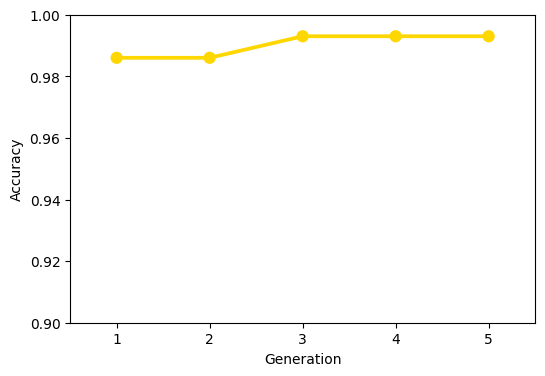

In [91]:
# iteration별 결과
plot(score_bc,0.9,1.0,c = "gold",n_gen=5)

###### reference : https://www.kaggle.com/code/tanmayunhale/genetic-algorithm-for-feature-selection

#### Example2

In [93]:
data_pd = pd.read_csv(path + "Parkinsson disease.csv")
label_pd = data_pd["status"]
data_pd.drop(["status","name"],axis = 1,inplace = True)

In [95]:
data_pd.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [118]:
logmodel = DecisionTreeClassifier(random_state=0)
X_train,X_test, Y_train, Y_test = split(data_pd,label_pd)
chromo_df_pd,score_pd=generations(data_pd,label_pd,size=100,n_feat=data_pd.shape[1],cutoff=0.3,n_parents=70,mutation_rate=0.20,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [0.9591836734693877]
Best score in generation 2 : [0.9387755102040817]
Best score in generation 3 : [0.9795918367346939]
Best score in generation 4 : [0.9591836734693877]
Best score in generation 5 : [0.9591836734693877]


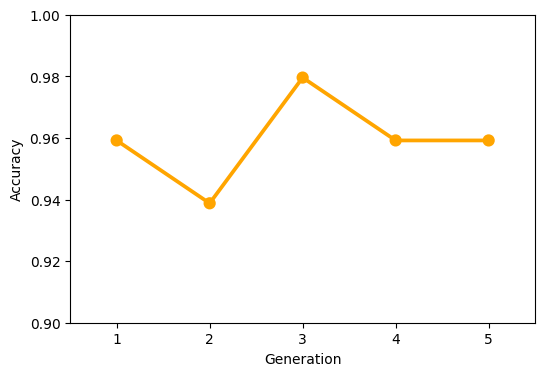

In [119]:
plot(score_pd,0.9,1.0,c = "orange",n_gen=5)

#### Example3


In [120]:
data_pcos = pd.read_csv(path + "PCOS_data.csv")
label_pcos = data_pcos["PCOS (Y/N)"]
data_pcos.drop(["Sl. No","Patient File No.","PCOS (Y/N)","Unnamed: 44","II    beta-HCG(mIU/mL)","AMH(ng/mL)"],axis = 1,inplace = True)
data_pcos["Marraige Status (Yrs)"].fillna(data_pcos['Marraige Status (Yrs)'].describe().loc[['50%']][0], inplace = True) 
data_pcos["Fast food (Y/N)"].fillna(1, inplace = True) 

In [121]:
data_pcos.head()

,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,28,44.6,152.0,19.3,15,78,22,10.48,2,5,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,36,65.0,161.5,24.9,15,74,20,11.70,2,5,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,33,68.8,165.0,25.3,11,72,18,11.80,2,5,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,37,65.0,148.0,29.7,13,72,20,12.00,2,5,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,25,52.0,161.0,20.1,11,72,18,10.00,2,5,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [124]:
logmodel = DecisionTreeClassifier(random_state=0)
X_train,X_test, Y_train, Y_test = split(data_pcos,label_pcos)
chromo_df_pcos,score_pcos=generations(data_pcos,label_pcos,size=80,n_feat=data_pcos.shape[1],cutoff=0.5,n_parents=64,mutation_rate=0.20,n_gen=10,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [0.8529411764705882]
Best score in generation 2 : [0.875]
Best score in generation 3 : [0.8676470588235294]
Best score in generation 4 : [0.8676470588235294]
Best score in generation 5 : [0.8602941176470589]
Best score in generation 6 : [0.8676470588235294]
Best score in generation 7 : [0.875]
Best score in generation 8 : [0.8676470588235294]
Best score in generation 9 : [0.8602941176470589]
Best score in generation 10 : [0.8823529411764706]


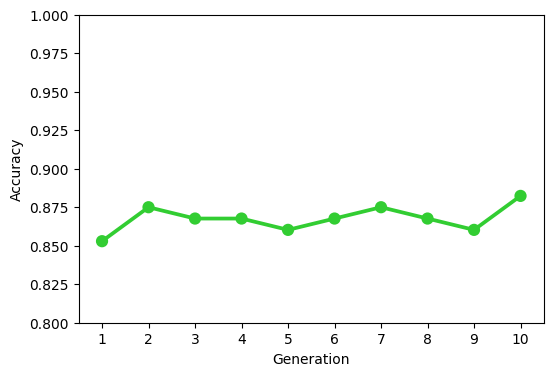

In [131]:
plot(score_pcos,0.8,1.0,c = "limegreen", n_gen=10)